In [724]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *
import seaborn as sns, numpy as np
import functools
from scipy.spatial.distance import squareform
import math

### IMPORTS

In [315]:
from Inference.Variational import MeanFieldVariationalDistribution

In [316]:
class VariationalGenerativeNetwork(nn.Module):
    def __init__(self, nntransform, lat_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(VariationalGenerativeNetwork, self).__init__()
        self.device = device
        self.lat_dim = lat_dim
        
        self.mfvar = MeanFieldVariationalDistribution(lat_dim,mu,sigma)
        self.nntransform = nntransform
        
          
    def sample(self, n=1):
        return self.nntransform(self.mfvar.sample(n))

In [317]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [318]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [319]:
torch.set_default_dtype(torch.float64)

# Model principal

In [889]:
mixture = [torch.distributions.normal.Normal(5.0, 0.5),
           torch.distributions.normal.Normal(-5.0, 1.5),
           torch.distributions.normal.Normal(2.0, 1.0)]
proportions = torch.tensor([0.05, 0.35, 0.6])

In [890]:
def logposterior(x):
    v = [None]*len(mixture)
    for j in range(len(mixture)):
        v[j] = mixture[j].log_prob(x) + proportions[j].log()
    return torch.logsumexp(torch.stack(v), dim=0)

<IPython.core.display.Javascript object>


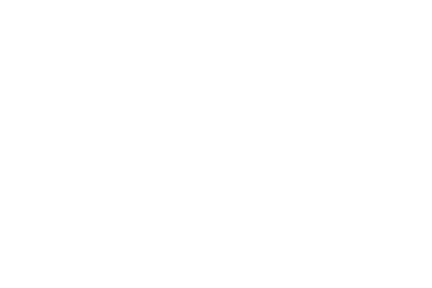

<IPython.core.display.Javascript object>


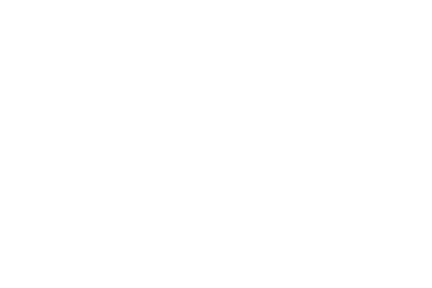

In [926]:
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), logposterior(x_lin).exp().detach().cpu().numpy())
plt.show()

# Modèle génératif: Hypernet autoencodeur

In [1283]:
lat_dim = 1
H = 20

In [1284]:
def LinSigmoid(x):
    return 1/(1+(math.e**-x)) + 0.05*x

In [1285]:
def LinTanh(x):
    return torch.tanh(x) + 0.01*x

In [1286]:
def LinSin(x):
    return torch.sin(x)+x

In [1287]:
class Net(nn.Module):
    def __init__(self,lat_dim,H):
        super(Net, self).__init__()
        
        self.L1 = nn.Linear(lat_dim, H)
        self.L2 = nn.Linear(H, H)
        self.L3 = nn.Linear(H, 1)

    def forward(self, input):
        h = LinTanh(self.L1(input))
        h = LinTanh(self.L2(h))
        h = self.L3(h)
        return h

In [1288]:
nntransform = Net(lat_dim,H)

In [1289]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0.0, std=1.0)
        torch.nn.init.normal_(m.bias, mean=0.0, std=1.0)

In [1290]:
nntransform.apply(init_weights)

Net(
  (L1): Linear(in_features=1, out_features=20, bias=True)
  (L2): Linear(in_features=20, out_features=20, bias=True)
  (L3): Linear(in_features=20, out_features=1, bias=True)
)

In [1291]:
q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device='cpu')
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

Parameter containing:
tensor([0.5413])

(-10, 10)

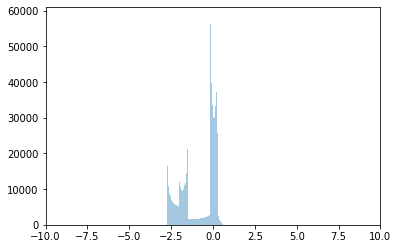

In [1292]:
with torch.no_grad():
    X = q.sample(1000000)
ax = sns.distplot(X.detach().numpy(), bins=100, kde=False)
ax.set_xlim(-10,10)

# Training #

In [1298]:
N_ELBO = 200

In [1309]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.001)

In [1310]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.1)

In [1311]:
%matplotlib inline
liveloss = PlotLosses()

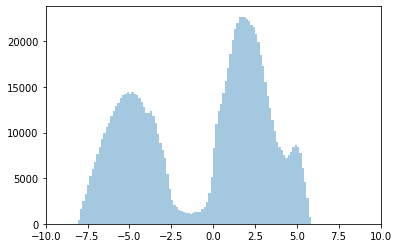

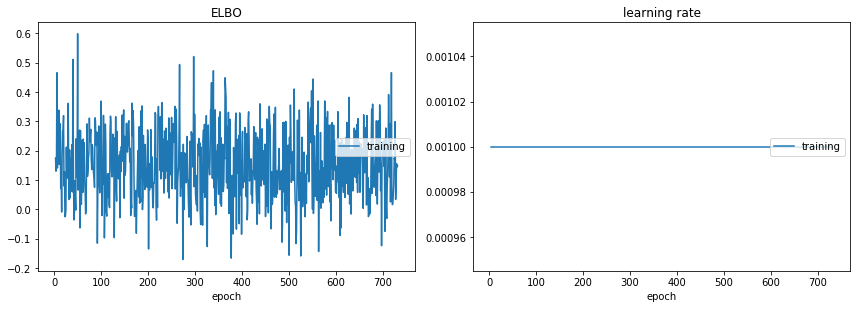

ELBO:
training   (min:   -0.171, max:    0.598, cur:    0.148)

learning rate:
training   (min:    0.001, max:    0.001, cur:    0.001)


In [ ]:
%matplotlib inline
liveloss = PlotLosses()

for t in range(100000):
    logs = {}
    optimizer.zero_grad()
    
    X = []
    for j in range(N_ELBO):
        X.append(q.sample())
    X = torch.cat(X,dim=0)

    LP = []
    for j in range(N_ELBO):
        z = X[j,:]
        LP.append(logposterior(z))
    ExpectedPosterior = torch.stack(LP).mean()
    
     
    D = torch.nn.functional.pdist(X)

    m = torch.zeros((N_ELBO-1, N_ELBO))
    tril_indices = torch.tril_indices(row=N_ELBO, col=N_ELBO, offset=-1)
    m[tril_indices[0]-1, tril_indices[1]] = D
    m[tril_indices[1], tril_indices[0]] = D

    (s,_) = torch.min(m,dim=0)

    Entropy = torch.sum(torch.log(s*N_ELBO))/N_ELBO + torch.tensor(2.0).log() + 0.57721
    
    L = -ExpectedPosterior-Entropy
    
    L.backward()
    optimizer.step()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    #scheduler.step(L.detach().clone().cpu().numpy())
    
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
  
    if t % 10 == 0:
        liveloss.draw()
        
        with torch.no_grad():
            X = q.sample(1000000)
        ax = sns.distplot(X.detach().numpy(), bins=100, kde=False)
        ax.set_xlim(-10,10)

    if learning_rate < 0.00001:
        break

# Résultats #

(-10, 10)

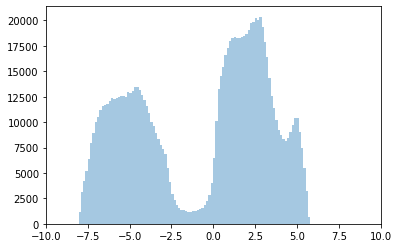

In [1308]:
%matplotlib inline
with torch.no_grad():
    X = q.sample(1000000)
ax = sns.distplot(X.detach().numpy(), bins=100, kde=False)
ax.set_xlim(-10,10)

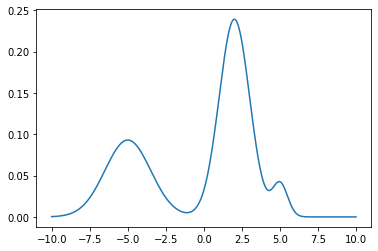

In [410]:
%matplotlib inline

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), logposterior(x_lin).exp().detach().cpu().numpy())
plt.show()

In [704]:
import math

In [816]:
import math
def f(x):
    return torch.sin(x)+x

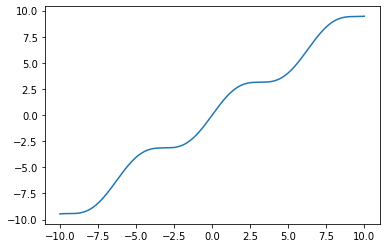

In [817]:
%matplotlib inline

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), f(x_lin).detach().cpu().numpy())
plt.show()